<a href="https://colab.research.google.com/github/SahputraS/Outbreak-Simulation-and-Detection-Testing/blob/main/SIRS_Metapopulation_With_Reporting.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import random
import seaborn as sns

from scipy.ndimage import gaussian_filter
from scipy.signal import windows

In [2]:
np.random.seed(2070778)
random.seed(2070778)

This project simulates the spread of an infectious disease using a spatial SIRS (Susceptible–Infected–Recovered–Susceptible) model across 25 regions over a 2000-day period. The simulation incorporates daily mobility between regions, allowing individuals to move spatially across a 5×5 grid. Disease dynamics—such as infection, recovery, and waning immunity—are modeled independently in each region, with transmission driven by a time-varying rate (β).

To simulate outbreak conditions, all regions experience an increase in transmission rate starting on the same day (t1), though the magnitude of this increase varies by region. This models spatial heterogeneity while maintaining a globally synchronized outbreak onset.

Real-world surveillance behavior is approximated by applying binomial underreporting to daily infection counts, with reporting rates doubled on weekends to reflect improved detection. The resulting time series of true and reported cases is exported as a CSV file for downstream testing of outbreak detection algorithms.

In [3]:
def mobility_grid(I_flat, sigma=1, jump_fraction=0.01, min_cell_value=5):
    '''
    This mobility function simulates how people move on a world made of grid cells.
    Each cell is a region.

    There is no birth/death. People lives eternally, therefore the sum of the matrix before and after movement should always be the same.

    The world is wrapped. This means if someone moves past the edge of the grid, they appear on the opposite side.
    It’s like how maps wrap around in our real world map. This helps avoid weird effects at the borders.

    People are more likely to move to neighboring cells than distant ones.
    This localized movement is modeled using a Gaussian kernel:
    - Immediate neighbors receive the most movement
    - Further cells receive exponentially less

    To avoid total homogenization over time, only a random fraction of people are allowed to move at each step.
    This move fraction is randomly sampled within a predefined range.

    Additionally, a small random fraction of people perform long-range "jumps" to random locations.
    This long-distance movement is not currently realistic but serves to introduce spatial noise/clustering.
    Future versions may refine this behavior.

    Pros:
    - Simple, flexible, and sufficient for generating larger space-time clusters
    - Encourages realistic spatial dispersion without full agent-based modeling

    Cons:
    - No attractive centers (gravity-based destinations)
    - No directionality or real-world transport pathways
    - Simplified long-range movement (fully random)

    Plans:
    - Add gravitational pull or destination bias (if needed)
    - Improve long-jump logic to be distance-aware or hotspot-targeted (if needed)

    '''

    # I want to make the flat array into square matrix to represent grid
    N = I_flat.size
    grid_size = int(np.sqrt(N))
    if grid_size ** 2 != N:
        raise ValueError("Input size is not a perfect square, cannot form a square grid.")

    I_map = I_flat.reshape((grid_size, grid_size))

    total_before = I_map.sum()

    # Draw random move fraction for local blur
    move_fraction = np.random.uniform(0.05, min(0.15, 1 - jump_fraction)) # Randomly picked the % of moving people out of predetermined threshold
    stay_fraction = 1 - move_fraction - jump_fraction

    # Local movement
    local_blur = gaussian_filter(I_map * move_fraction, sigma=sigma, mode="wrap")

    # Long-range jump setup
    jumpers_mask = I_map >= min_cell_value # Cell that allows the long range jump is only if there are minimum X people
    jumpers = I_map * jump_fraction * jumpers_mask # Calculate the number of jumpers
    I_core = I_map * stay_fraction

    # Do the jump
    total_jumpers = jumpers.sum()
    if total_jumpers > 0:
        rand_field = np.random.rand(grid_size, grid_size)
        rand_field /= rand_field.sum()
        jump_map = total_jumpers * rand_field
    else:
        jump_map = np.zeros_like(I_map)

    # Combine
    new_I_map = I_core + local_blur + jump_map

    # Because the number in each cells needs to be integer (number of people) and total number of the population must be fixed
    # My band-aid method is as below:

    # The float numbers need to be rounded down to integer
    new_I_map = np.floor(new_I_map).astype(int)

    # Therefore must be some difference because of the rounding down
    delta = int(total_before - new_I_map.sum())

    if delta != 0: # If indeed there are some difference
        candidates = np.argwhere(new_I_map >= min_cell_value) # Find cells with values less than threshold (i.e. min_cell_value) as candidate to be modified
        if len(candidates) == 0: # Sanity check, if there is no candidate then make an error
            raise ValueError("No valid cells to adjust population.")

        # Randomly select cells to add or substract to fix the total sum
        chosen_indices = candidates[np.random.choice(len(candidates), abs(delta), replace=True)]
        for x, y in chosen_indices:
            new_I_map[x, y] += 1 if delta > 0 else -1 # Add or subtract 1 depending on whether rounding caused a deficit or surplus

    assert new_I_map.sum() == total_before, "Population not conserved after fix"
    assert np.all(new_I_map >= 0), "Negative population created"

    return new_I_map.flatten()

In [4]:
def reporting_dynamic(true_cases, t, r, reporting_delay, reporting_rate, days, use_delay=True):
    """
    true_cases (int): Number of actual new cases.
    t (int): Current day.
    r (int): Region index.
    reporting_delay (array): Delay matrix (regions x days).
    reporting_rate (float): Base reporting rate (e.g., 0.6).
    days (int): Total number of days in simulation.
    """
    weekday = t % 7 # Indexing the date as days
    rate = reporting_rate * (1.0 if weekday in [5, 6] else 0.5) # Weekend reports are doubles of that in weekday
    reported = np.random.binomial(n=int(true_cases), p=rate) # The report are modelled by binomial

    delay = reporting_delay[r, t] if use_delay else 0 # If i want to make a delay (just in case)
    report_day = t + delay # Then the report will be delayed

    if report_day < days:
        return report_day, reported
    else:
        return None, 0 # Stop when outside the simulated day range

In [5]:
def sirs_transitions(S_prev, I_prev, R_prev, N_total, beta, gamma, waning_rate):

    # Infection probability
    p_infect = beta * (I_prev / N_total)
    if p_infect >= 1: # Sanity check if the infection probability is more than 1, there is something wrong
        raise ValueError(f"Invalid infection probability: {p_infect:.3f}. Check beta or population size.")

    # Transitions
    now_infected = np.random.binomial(n=int(S_prev), p=p_infect)
    now_recovered = np.random.binomial(n=int(I_prev), p=gamma)
    now_susceptible = np.random.binomial(n=int(R_prev), p=waning_rate)

    # Updated compartments
    S_now = S_prev - now_infected + now_susceptible
    I_now = I_prev + now_infected - now_recovered
    R_now = R_prev + now_recovered - now_susceptible

    return S_now, I_now, R_now, now_infected, now_recovered, now_susceptible

In [6]:
def generate_beta_schedule(beta_low, beta_high, t1, t2, days, plot=True):

    """
    This function creates a time-varying beta schedule for each region with a linear increase from t1 to t2 (time when it reaches the peak),
    and optionally plots the beta evolution. The aim is to better reflect real-world outbreak dynamics, where transmission increases gradually instead of spiking suddenly.
    """

    regions = len(beta_low)
    t = np.arange(days)

    # Create the rising shape of beta using a linear gradient between 0 and 1
    # The increase starts at t1 and reaches 1 by t2, after which it stays constant at 1
    shape = np.zeros(days)
    rise_idx = (t >= t1) & (t < t2)
    shape[rise_idx] = (t[rise_idx] - t1) / (t2 - t1)
    shape[t >= t2] = 1

    # Make the array of beta values throughout the simulated days for all regions, named beta_schedule
    beta_schedule = np.zeros((regions, days))
    for r in range(regions):
        beta_schedule[r, :] = beta_low[r] + (beta_high[r] - beta_low[r]) * shape

    # True outbreak labels
    true_outbreak_label = np.zeros((regions, days), dtype=int)
    true_outbreak_label[:, t1:] = 1

    # Optional plot
    if plot:
        plt.figure(figsize=(10, 5))
        region_id = 2  # Just for a sample case
        plt.plot(beta_schedule[region_id], label=f'Region {region_id}')
        plt.axvline(t1, color='red', linestyle='--', label='Outbreak Start (t1)')
        plt.axvline(t2, color='orange', linestyle='--', label='Outbreak Peak (t2)')
        plt.title("Beta Schedule Over Time")
        plt.xlabel("Day")
        plt.ylabel("Beta Value")
        plt.legend()
        plt.grid(True)
        plt.tight_layout()
        plt.show()

    return beta_schedule, true_outbreak_label

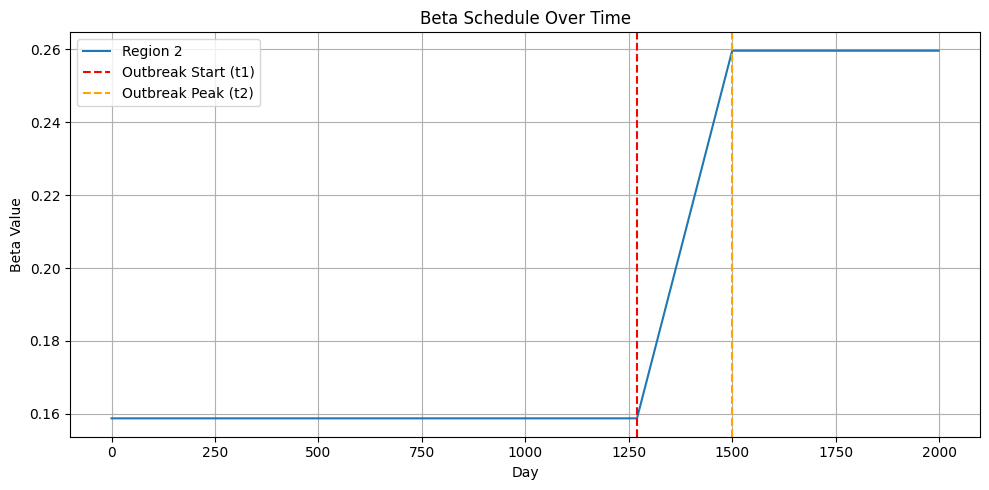

In [7]:
## Parameters
# SIRS
regions = 25                         # Number of spatial regions must be able to be squared (weakness for now, to be fixed later)
N_current = [1000] * regions         # Population per region

gamma = 1/10                        # Recovery rate
waning_rate = 1/30                  # Rate of losing immunity and back being susceptible
days = 2000                         # Duration of simulation
initial_infected = [30] * regions   # Initial infected per region
initial_recovered = [30] * regions  # Initial recovered per region

##### Beta scheduling experiment where the beta increase step by step to the outbreak high value
beta_schedule, true_outbreak_label = generate_beta_schedule(
    beta_low=np.random.uniform(0.15, 0.19, 25), # Infection rate during non outbreak period
    beta_high=np.random.uniform(0.25, 0.3, 25), # Infection rate that causes outbreak
    t1=1270,
    t2=1500,
    days=days,
    plot=True
)
##########

# Reporting
reporting_rate_array = [0.8] * regions  # Reporting rate per region
reported_cases = np.zeros((regions, days)) # Initialization for the reported cases array

# If i want the delay
max_delay = 3             # cap reporting delay
delay_dist = np.random.poisson
reporting_delay = np.minimum(delay_dist(2, size=(regions, days)), max_delay)


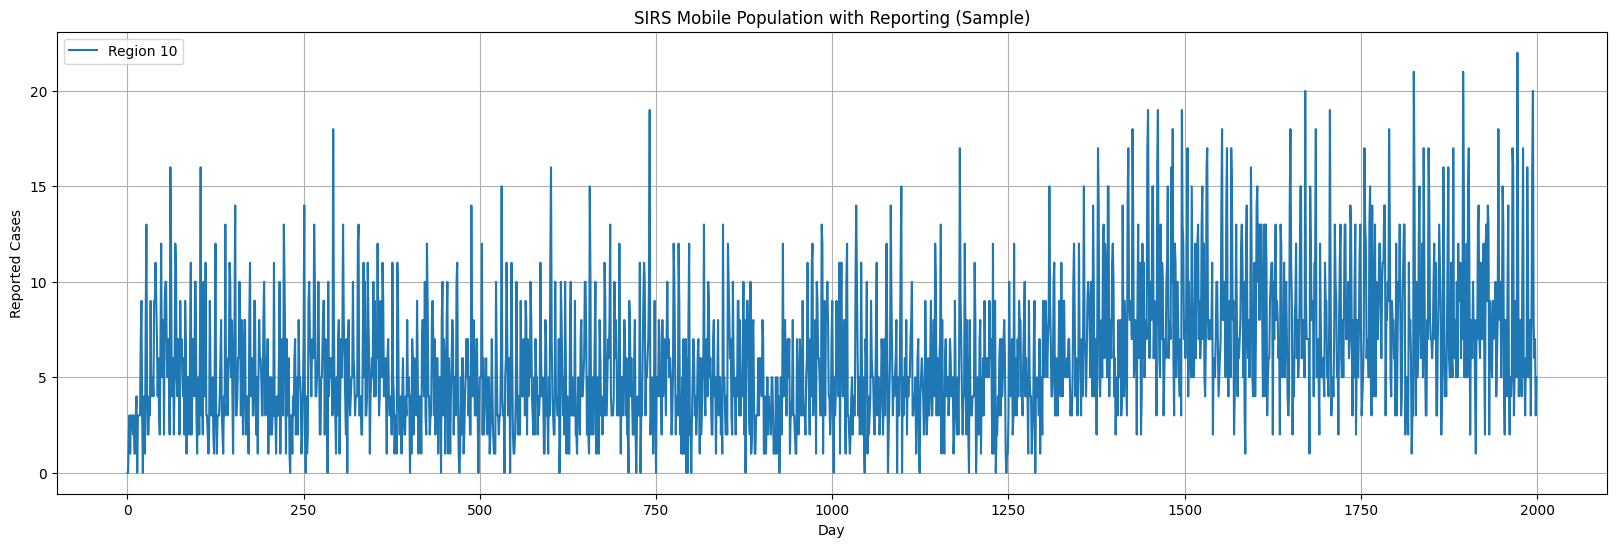

In [8]:
# Initialize SIR arrays
S = np.zeros((regions, days))
I = np.zeros((regions, days))
R = np.zeros((regions, days))
for r in range(regions):
    S[r, 0] =  N_current[r] - initial_infected[r] - initial_recovered[r]
    I[r, 0] = initial_infected[r]
    R[r, 0] = initial_recovered[r]


for t in range(1, days):
    for r in range(regions):

       #1. Disease simulation (normal days and outbreak)
        beta = beta_schedule[r, t]
        # SIRS dynamics
        S[r, t], I[r, t], R[r, t], new_infected, new_recovered, new_susceptible = sirs_transitions(
            S_prev=S[r, t-1],
            I_prev=I[r, t-1],
            R_prev=R[r, t-1],
            N_total=N_current[r],
            beta=beta,
            gamma=gamma,
            waning_rate=waning_rate
        )

        #2. Reporting
        reporting_rate = reporting_rate_array[r] # Begin with low report since there is no outbreak

        report_day, reported = reporting_dynamic(
            true_cases=new_infected,
            t=t,
            r=r,
            reporting_delay=reporting_delay,
            reporting_rate=reporting_rate,
            days=days,
            use_delay=False  #false for instant reporting
        )

        if report_day is not None:
            reported_cases[r, report_day] += reported


    # #3. Mobility
    S[:, t] = mobility_grid(S[:, t], sigma=1.2, jump_fraction=0.05, min_cell_value=5)
    I[:, t] = mobility_grid(I[:, t], sigma=1.2, jump_fraction=0.05, min_cell_value=5)
    R[:, t] = mobility_grid(R[:, t], sigma=1.2, jump_fraction=0.05, min_cell_value=5)
    N_current = S[:, t] + I[:, t] + R[:, t]

# Compile results
data = pd.DataFrame([
    {'Day': t, 'Region': r,
     'Susceptible': S[r, t], 'Infected': I[r, t],
     'Recovered': R[r, t], 'Reported Cases': reported_cases[r, t], 'True Outbreak': true_outbreak_label[r, t]}
    for r in range(regions) for t in range(days)
])

# Plot reported cases over time for each region
r = 10
plt.figure(figsize=(20, 6))
subset = data[data['Region'] == r]
plt.plot(subset['Day'], subset['Reported Cases'], label=f'Region {r}')
plt.xlabel('Day')
plt.ylabel('Reported Cases')
plt.title('SIRS Mobile Population with Reporting (Sample)')
plt.legend()
plt.grid(True)
plt.show()

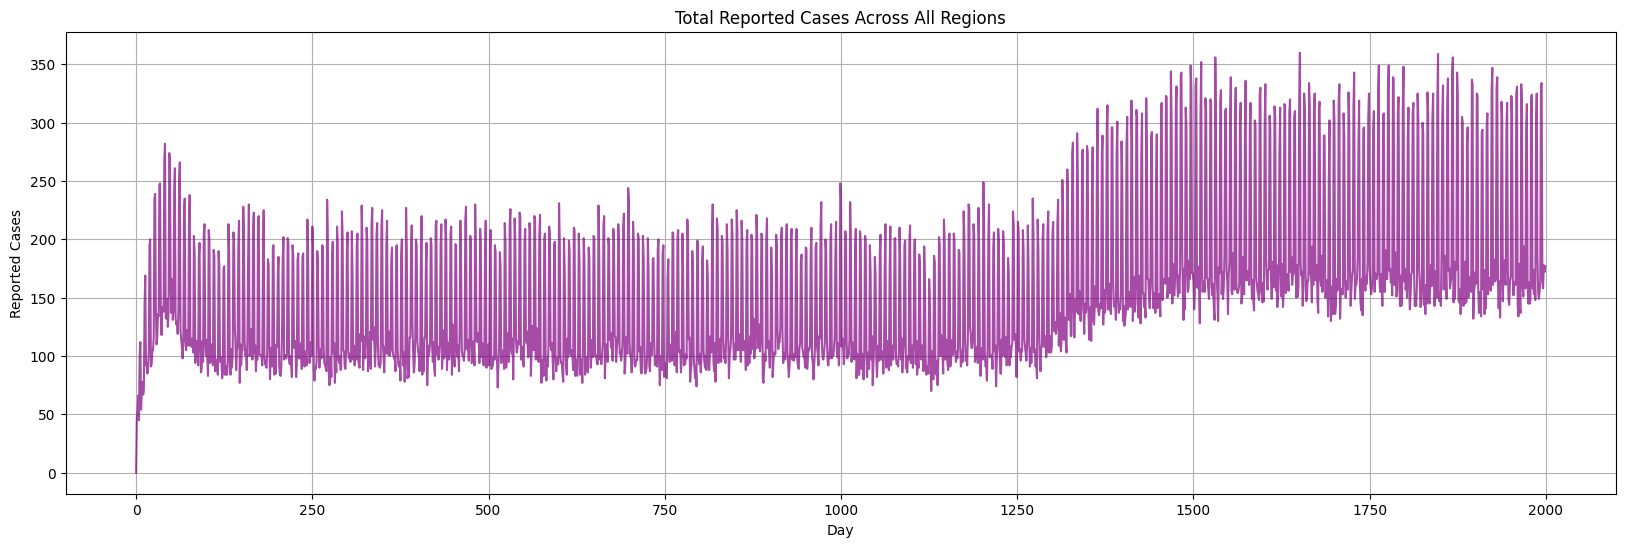

In [9]:
plt.figure(figsize=(20, 6))

# Sum reported cases across all regions for each day
sum_reported = data.groupby('Day')['Reported Cases'].sum()

plt.plot(sum_reported.index, sum_reported.values, color='purple', alpha=0.7)
plt.xlabel('Day')
plt.ylabel('Reported Cases')
plt.title('Total Reported Cases Across All Regions')
plt.grid(True)
plt.show()

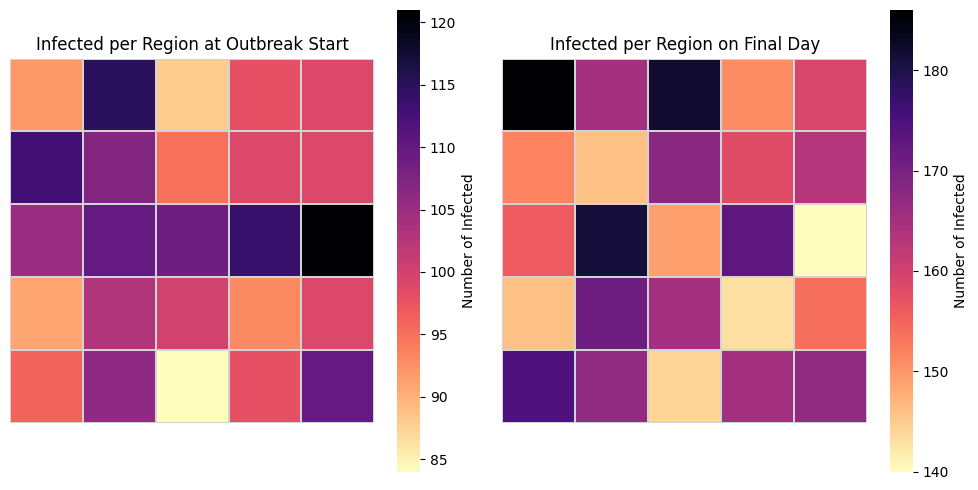

In [10]:
# I want to plot the heatmap of number of infected people per region
initial_outbreak = data.loc[data["Day"] == 1270, "Infected"].values
last_day_simulation = data.loc[data["Day"] == 1999, "Infected"].values

grid_size = int(np.sqrt(initial_outbreak.size))
before_plot = initial_outbreak.reshape((grid_size, grid_size))
after_plot = last_day_simulation.reshape((grid_size, grid_size))


fig, axes = plt.subplots(1, 2, figsize=(10, 5))

# Heatmap
sns.heatmap(before_plot, ax=axes[0], cmap='magma_r', cbar=True, square=True,
            linewidths=0.1, linecolor='lightgrey',
            cbar_kws={'label': 'Number of Infected'})
axes[0].set_title("Infected per Region at Outbreak Start")
axes[0].axis('off')

sns.heatmap(after_plot, ax=axes[1], cmap='magma_r', cbar=True, square=True,
            linewidths=0.1, linecolor='lightgrey',
            cbar_kws={'label': 'Number of Infected'})
axes[1].set_title("Infected per Region on Final Day")
axes[1].axis('off')

plt.tight_layout()
plt.show()

## Saving in the Google Drive

In [11]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [12]:
import os
os.makedirs("/content/drive/MyDrive/simulation", exist_ok=True)

In [13]:
output_path = "/content/drive/MyDrive/simulation/simulation_data(grid-2000 days).csv"
data.to_csv(output_path, index=False)